# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')

In [3]:
full_df = pd.read_csv('data/winequalityN.csv')

full_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Model

In [69]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.utils.multiclass import unique_labels

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

set_config(display='diagram')

In [6]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [76]:
def score_classification_model(model, X_train, y_train):
    
    cv_scores = cross_validate(
        model, X_train, y_train, 
        scoring=['f1_weighted', 'balanced_accuracy'],
        cv=5,
        n_jobs=-1, verbose=0
    )

    cv_y_predicted = cross_val_predict(
        model, X_train, y_train,
        cv=5,
        n_jobs=-1
    )

    cv_f1_weighted, f1_weighted_std = cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std()
    cv_balanced_accuracy, balanced_accuracy_std = cv_scores['test_balanced_accuracy'].mean(), cv_scores['test_balanced_accuracy'].std()

    model.fit(X_train, y_train)

    y_train_predicted = model.predict(X_train)

    train_f1_weighted = f1_score(y_train, y_train_predicted, average='weighted')
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_predicted)

    print('[Train] F1 Weighted: %.4f' % (train_f1_weighted))
    print('[Train] Balanced Accuracy: %.4f' % (train_balanced_accuracy))
    print('Train Set Report:')
    print(classification_report(y_train, y_train_predicted, digits=3))

    print('[CV] F1 Weighted: %.4f (%.4f)' % (cv_f1_weighted, f1_weighted_std))
    print('[CV] Balanced Accuracy: %.4f (%.4f)' % (cv_balanced_accuracy, balanced_accuracy_std))
    print('CV Report:')
    print(classification_report(y_train, cv_y_predicted, digits=3))
    
    # display confusion matrixes

    _, (ax0, ax1) = plt.subplots(1, 2)

    ax0.set_title('Train Confusion Matrix')
    plot_confusion_matrix(
        model, X_train, y_train,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax0,
        colorbar=False,
    )

    ax1.set_title('CV Confusion Matrix')
    plot_confusion_matrix_by_predictions(
        y_train, cv_y_predicted,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax1,
        colorbar=False,
    )

In [8]:
# sklearn's pipeline API is limited at this point and doesn't provide a way to get columns of transformed X array
# This snippet will cover our back 

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    [_, _, reminder_columns] = column_transformer.transformers_[-1]

    for col_idx in reminder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

# Test Dataset Distribution

# Feature Engineering

In [56]:
full_df['fixed_acidity_red_wine'] = (full_df['type'] == 'red') * full_df['fixed acidity']
full_df['fixed_acidity_white_wine'] = (full_df['type'] == 'white') * full_df['fixed acidity']

full_df['molecular_sulfur_dioxid'] = full_df['free sulfur dioxide'] / (1 + 10 ** (full_df['pH'] - 1.8))
full_df['free_total_so2_rate'] = full_df['free sulfur dioxide'] / full_df['total sulfur dioxide']
full_df['bound_sulfur_dioxid'] = full_df['total sulfur dioxide'] - full_df['free sulfur dioxide']

Feature Engineering:
- `total sulfur dioxide` - doesn't improve models in a raw view

In [57]:
model_features = [
    'type',
    'alcohol',
    'fixed acidity',
    #'fixed_acidity_red_wine',
    #'fixed_acidity_white_wine',
    'volatile acidity',
    'citric acid',
    'pH',
    'residual sugar',
    'free sulfur dioxide',
    'chlorides',
    'density',
    'sulphates',
    'bound_sulfur_dioxid'
]

X = full_df[model_features]
y = full_df['quality']

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in stratified_splitter.split(X, y):
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

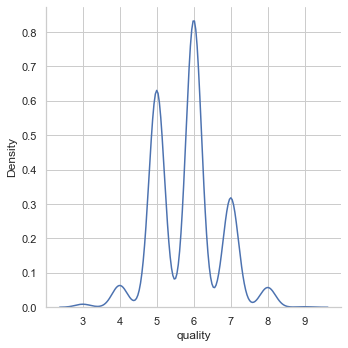

In [10]:
sns.displot(data=y_test, kind='kde')

In [11]:
y_test.value_counts()

6    567
5    428
7    216
4     43
8     39
3      6
9      1
Name: quality, dtype: int64

In [12]:
X_test['type'].value_counts()

white    967
red      333
Name: type, dtype: int64

# Data Processing

In [135]:
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

numerical_scaler = Pipeline([
    ('imputing', SimpleImputer(strategy='median')),
    ('log_transforming', log_transformer),
])

featureTransformer = ColumnTransformer([
        ('feature_scaling', numerical_scaler, ['fixed acidity', 'chlorides', 'citric acid', 'volatile acidity', 'sulphates']),
        ('feature_imputing', SimpleImputer(strategy='median'), [
            'pH', 'density', 'residual sugar', 'bound_sulfur_dioxid'
        ]),
        ('wine_type_onehot', OneHotEncoder(), ['type']),
    ],
    remainder='passthrough'
)

# LogisticRegression

In [136]:
logistic_regression = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    C=0.95,
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

logistic_regression_pipeline = Pipeline([
    ('feature_processing', featureTransformer),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_regression),
])

logistic_regression_pipeline

## F1 Weighted: 0.2895 (0.0135), Balanced Accuracy: 0.3349 (0.0429)
# solver='lbfgs',
# C=0.95,
# max_iter=2000,
# class_weight='balanced'

## F1 Weighted: 0.4395 (0.0177), Balanced Accuracy: 0.3591 (0.0586)
# solver='liblinear',
# penalty='l1',
# C=1,
# max_iter=2000,
# class_weight='balanced'

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_scaling',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transforming',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['fixed acidity', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates']),
                                                 ('feature_imputing',
                                                  SimpleImputer(strategy='median'),
                                                  ['pH', 'density',
                                                   'residual sugar',
                                                   'bound_sulfur_dioxid']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(C=0.95, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, penalty='l1',
                                    random_state=42, solver='liblinear'))])

[Train] F1 Weighted: 0.4931
[Train] Balanced Accuracy: 0.4775
Train Set Report:
              precision    recall  f1-score   support

           3      0.029     0.292     0.052        24
           4      0.198     0.335     0.249       173
           5      0.588     0.595     0.592      1710
           6      0.576     0.438     0.498      2269
           7      0.400     0.403     0.402       863
           8      0.150     0.279     0.195       154
           9      0.085     1.000     0.157         4

    accuracy                          0.476      5197
   macro avg      0.289     0.478     0.306      5197
weighted avg      0.523     0.476     0.493      5197

[CV] F1 Weighted: 0.4889 (0.0133)
[CV] Balanced Accuracy: 0.3657 (0.0396)
CV Report:
              precision    recall  f1-score   support

           3      0.012     0.125     0.022        24
           4      0.186     0.318     0.235       173
           5      0.583     0.591     0.587      1710
           6      0.5

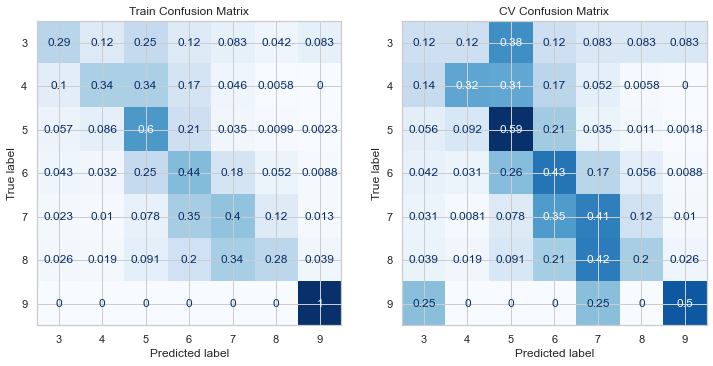

In [137]:
score_classification_model(logistic_regression_pipeline, X_train, y_train)

## Hyperparam Tuning

In [16]:
parameters = {
    'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
    'quality_classification__C': [1.0, 0.95, 0.9, 0.8], # 1.0
    'quality_classification__tol': [1e-4],
    'quality_classification__class_weight': ['balanced'],
    'quality_classification__solver': ['lbfgs', 'liblinear', 'sag', 'saga'], # lbfgs
    'quality_classification__max_iter': [2000, 2500],
    'quality_classification__l1_ratio': [1.0, 0.0, 0.3, 0.4, 0.5],
}

param_searcher = GridSearchCV(
   estimator=logistic_regression_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Polynomial Regression

In [140]:
logistic_classifier = LogisticRegression(
    penalty='none',
    solver='newton-cg',
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

polynomial_pipeline = Pipeline([
    ('feature_processing', featureTransformer),
    ('scaling', StandardScaler()),
    ('polynomial_features', PolynomialFeatures(interaction_only=True)),
    ('quality_classification', logistic_classifier),
])

polynomial_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_scaling',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transforming',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['fixed acidity', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates']),
                                                 ('feature_...
                                                  SimpleImputer(strategy='median'),
                                                  ['pH', 'density',
                                                   'residual sugar',
                                                   'bound_sulfur_dioxid']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('scaling', StandardScaler()),
                ('polynomial_features',
                 PolynomialFeatures(interaction_only=True)),
                ('quality_classification',
                 LogisticRegression(class_weight='balanced', penalty='none',
                                    random_state=42, solver='newton-cg'))])

[Train] F1 Weighted: 0.4498
[Train] Balanced Accuracy: 0.6597
Train Set Report:
              precision    recall  f1-score   support

           3      0.102     0.958     0.184        24
           4      0.174     0.699     0.279       173
           5      0.604     0.527     0.563      1710
           6      0.622     0.301     0.405      2269
           7      0.395     0.444     0.418       863
           8      0.149     0.688     0.245       154
           9      1.000     1.000     1.000         4

    accuracy                          0.427      5197
   macro avg      0.435     0.660     0.442      5197
weighted avg      0.547     0.427     0.450      5197

[CV] F1 Weighted: 0.4207 (0.0170)
[CV] Balanced Accuracy: 0.3458 (0.0216)
CV Report:
              precision    recall  f1-score   support

           3      0.031     0.208     0.055        24
           4      0.118     0.451     0.187       173
           5      0.579     0.517     0.546      1710
           6      0.5

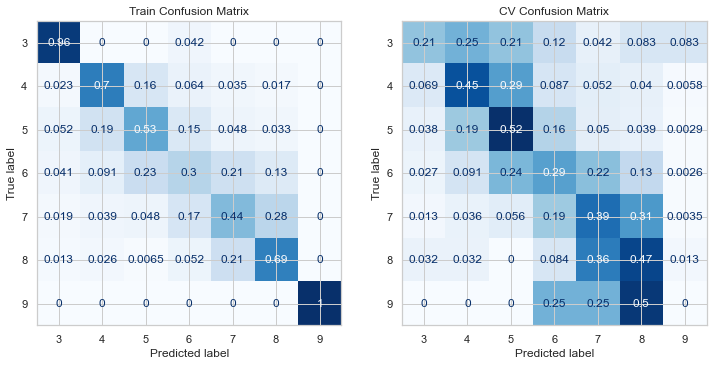

In [141]:
score_classification_model(polynomial_pipeline, X_train, y_train)

### Hyperparam Tuning

In [133]:
parameters = [
    {
        'quality_classification__solver': ['newton-cg'], # lbfgs, liblinear, 'lbfgs', 'sag', 'saga',
        'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
        'quality_classification__C': [1.0], # 1.0
        'quality_classification__l1_ratio': [1.0, 0.9],
        'quality_classification__max_iter': [100],
        'quality_classification__class_weight': ['balanced'],
        'polynomial_features__degree': [2],
        'polynomial_features__interaction_only': [True],
    },
]

param_searcher = GridSearchCV(
   estimator=polynomial_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

param_searcher.fit(X_train, y_train)
param_searcher.best_params_, param_searcher.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

## RandomForest

In [143]:
rf_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=60,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

rf_pipeline = Pipeline([
    ('feature_processing', featureTransformer),
    ('quality_classification', rf_classifier),
])

rf_pipeline


Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_scaling',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transforming',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['fixed acidity', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates']),
                                                 ('feature_imputing',
                                                  SimpleImputer(strategy='median'),
                                                  ['pH', 'density',
                                                   'residual sugar',
                                                   'bound_sulfur_dioxid']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='sqrt', min_samples_leaf=5,
                                        min_samples_split=20, n_estimators=60,
                                        random_state=42))])

[Train] F1 Weighted: 0.7949
[Train] Balanced Accuracy: 0.9208
Train Set Report:
              precision    recall  f1-score   support

           3      0.750     1.000     0.857        24
           4      0.662     0.994     0.794       173
           5      0.816     0.825     0.820      1710
           6      0.885     0.688     0.774      2269
           7      0.666     0.939     0.779       863
           8      0.806     1.000     0.893       154
           9      1.000     1.000     1.000         4

    accuracy                          0.796      5197
   macro avg      0.798     0.921     0.845      5197
weighted avg      0.815     0.796     0.795      5197

[CV] F1 Weighted: 0.5810 (0.0056)
[CV] Balanced Accuracy: 0.3974 (0.0351)
CV Report:
              precision    recall  f1-score   support

           3      0.250     0.125     0.167        24
           4      0.266     0.283     0.275       173
           5      0.647     0.694     0.670      1710
           6      0.6

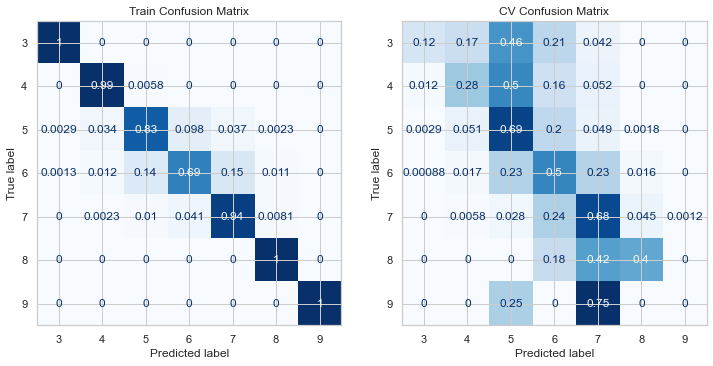

In [144]:
score_classification_model(rf_pipeline, X_train, y_train)

### Hyperparam Tuning

In [22]:
parameters = {
    'quality_classification__n_estimators': [50, 100, 150, 200],
    'quality_classification__criterion': ['entropy'], # 'gini',
    'quality_classification__max_features': [None, 'sqrt', 'log2', 'auto'],
    'quality_classification__max_depth': [None], # 3, 4, 5
    'quality_classification__min_samples_split': [15, 20, 25], # 2
    'quality_classification__min_samples_leaf': [4, 5, 6], # 2
    'quality_classification__class_weight': ['balanced'],
}

param_searcher = GridSearchCV(
   estimator=rf_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Model Inspection

In [92]:
X_train_processed_columns = get_columns_from_transformer(rf_pipeline.named_steps['feature_processing'], list(X_train.columns))

In [105]:
features_list = sorted(zip(rf_pipeline.named_steps['quality_classification'].feature_importances_, X_train_processed_columns), reverse=True)
features_list

[(0.13788187733351392, 'alcohol'),
 (0.13699234642831146, 'density'),
 (0.1286297935533968, 'chlorides'),
 (0.09598451533663135, 'free sulfur dioxide'),
 (0.09284829612530478, 'volatile acidity'),
 (0.06975752475544028, 'pH'),
 (0.0687930192211386, 'residual sugar'),
 (0.06802435124169887, 'bound_sulfur_dioxid'),
 (0.06790160865691365, 'citric acid'),
 (0.06766587435419481, 'fixed acidity'),
 (0.057990542353694274, 'sulphates'),
 (0.004525633709855103, 'type_white'),
 (0.0030046169299059408, 'type_red')]

In [25]:
# from eli5.sklearn import PermutationImportance
# from eli5 import show_weights

# X_train_processed = rf_pipeline.named_steps['feature_processing'].transform(X_train)

# permutation_importance = PermutationImportance(
#     rf_classifier, 
#     scoring='balanced_accuracy',
#     #cv=5,
#     random_state=RANDOM_SEED,
# )

# permutation_importance.fit(X_train_processed, y_train)
# show_weights(permutation_importance, feature_names=X_train_processed_columns, top=20)

# Generalization

In [129]:
def score_model_generalization(model, X_test, y_test):
    y_test_predicted = model.predict(X_test)

    test_f1_weighted = f1_score(y_test, y_test_predicted, average='weighted')
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)

    print('[Test] F1 Weighted: %.4f' % (test_f1_weighted))
    print('[Test] Balanced Accuracy: %.4f' % (test_balanced_accuracy))
    print('Test Set Report:')
    print(classification_report(y_test, y_test_predicted, digits=3))

    plot_confusion_matrix_by_predictions(
        y_test, y_test_predicted,
        cmap=plt.cm.Greens,
        normalize='true',
        colorbar=False,
    )

## Logistic Regression

[Test] F1 Weighted: 0.4800
[Test] Balanced Accuracy: 0.2573
Test Set Report:
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         6
           4      0.130     0.209     0.161        43
           5      0.562     0.603     0.582       428
           6      0.563     0.423     0.483       567
           7      0.412     0.412     0.412       216
           8      0.109     0.154     0.128        39
           9      0.000     0.000     0.000         1

    accuracy                          0.463      1300
   macro avg      0.254     0.257     0.252      1300
weighted avg      0.507     0.463     0.480      1300



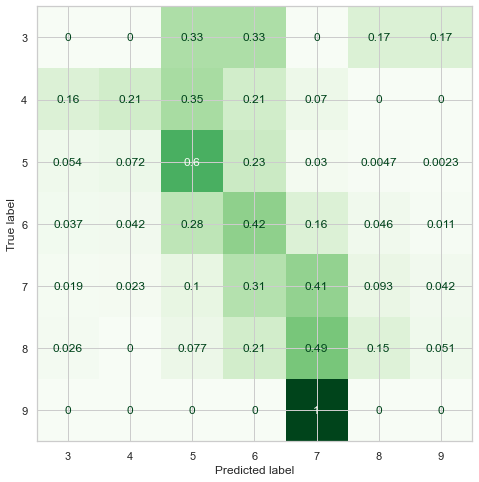

In [139]:
score_model_generalization(logistic_regression_pipeline, X_test, y_test)

## Polynomial Regression

[Test] F1 Weighted: 0.4282
[Test] Balanced Accuracy: 0.3080
Test Set Report:
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         6
           4      0.114     0.442     0.182        43
           5      0.578     0.519     0.547       428
           6      0.616     0.305     0.408       567
           7      0.355     0.352     0.353       216
           8      0.110     0.538     0.183        39
           9      0.000     0.000     0.000         1

    accuracy                          0.393      1300
   macro avg      0.253     0.308     0.239      1300
weighted avg      0.525     0.393     0.428      1300



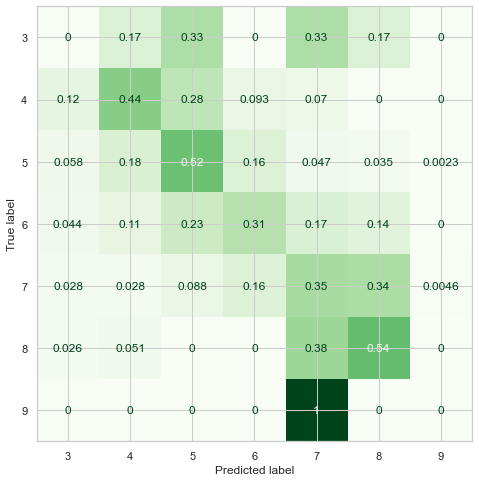

In [146]:
score_model_generalization(polynomial_pipeline, X_test, y_test)

## Random Forest

[Test] F1 Weighted: 0.6024
[Test] Balanced Accuracy: 0.3818
Test Set Report:
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         6
           4      0.368     0.326     0.346        43
           5      0.647     0.703     0.674       428
           6      0.681     0.527     0.594       567
           7      0.488     0.731     0.585       216
           8      0.455     0.385     0.417        39
           9      0.000     0.000     0.000         1

    accuracy                          0.605      1300
   macro avg      0.377     0.382     0.374      1300
weighted avg      0.617     0.605     0.602      1300



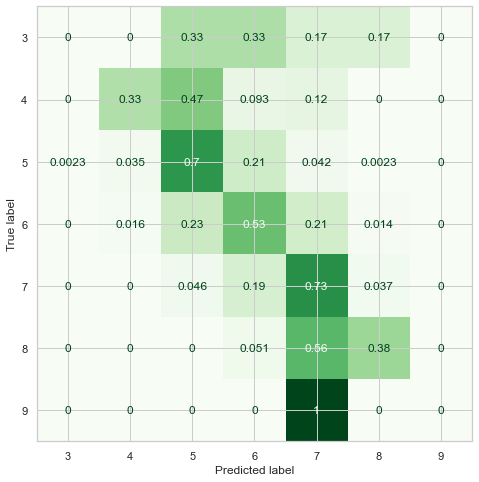

In [148]:
score_model_generalization(rf_pipeline, X_test, y_test)